<a href="https://colab.research.google.com/github/lavaskiller/smart_bin_proj/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1530 files belonging to 3 classes.
Using 1224 files for training.
Found 1530 files belonging to 3 classes.
Using 306 files for validation.
['can', 'coffee_pet', 'usual_pet']
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 360, 480, 3)       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 360, 480, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 360, 480, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 180, 240, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 240, 16)      0         
_______

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


39/39 [==============================] - 46s 1s/step - loss: 1.1148 - accuracy: 0.7655 - val_loss: 0.4640 - val_accuracy: 0.8497
Epoch 2/100
39/39 [==============================] - 4s 109ms/step - loss: 0.4278 - accuracy: 0.8374 - val_loss: 0.3086 - val_accuracy: 0.8922
Epoch 3/100
39/39 [==============================] - 4s 107ms/step - loss: 0.3747 - accuracy: 0.8464 - val_loss: 0.2957 - val_accuracy: 0.8824
Epoch 4/100
39/39 [==============================] - 4s 108ms/step - loss: 0.3325 - accuracy: 0.8717 - val_loss: 0.2830 - val_accuracy: 0.8824
Epoch 5/100
39/39 [==============================] - 4s 108ms/step - loss: 0.3133 - accuracy: 0.8791 - val_loss: 0.2831 - val_accuracy: 0.8889
Epoch 6/100
39/39 [==============================] - 4s 108ms/step - loss: 0.2929 - accuracy: 0.8840 - val_loss: 0.3364 - val_accuracy: 0.8922
Epoch 7/100
39/39 [==============================] - 4s 108ms/step - loss: 0.2829 - accuracy: 0.8864 - val_loss: 0.3112 - val_accuracy: 0.8824
Epoch 8/100
3

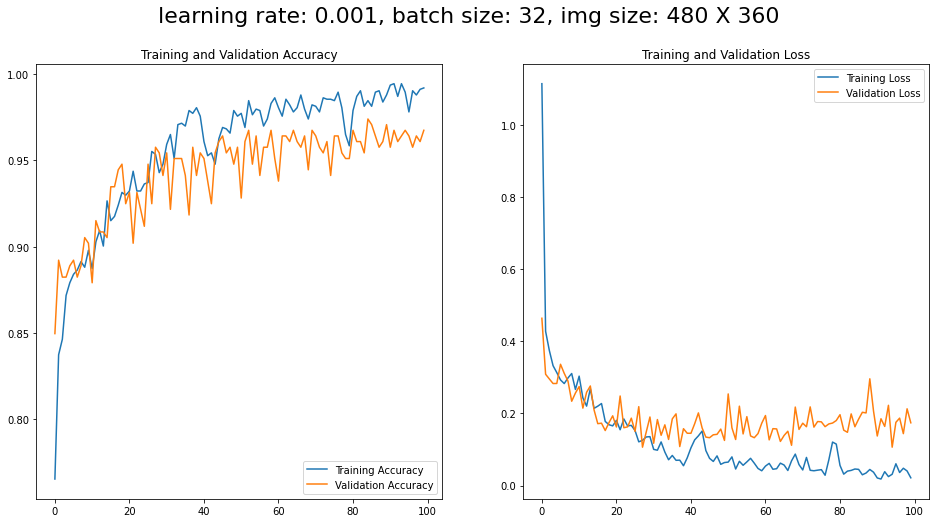

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import metrics, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras import activations
from tensorflow.python.keras.layers.pooling import MaxPool2D

###################### 변수 #####################
batch_size = 32
epochs = 100
img_height = 360
img_width = 480
learning_rate = 0.001
#################################################

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/gdrive/My Drive/all',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/gdrive/My Drive/all',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


#데이터 세트 구성 & 데이터 증강
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
])

augment = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.3)
])

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(type(train_ds))

#데이터 표준화
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch  = next(iter(normalized_ds))
labels_batch = next(iter(normalized_ds))


#모델 만들기
num_classes = 5


model = Sequential([
  resize_and_rescale,
  augment,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  Dropout(0.1),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax")
])
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#모델 컴파일
model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#모델 요약
model.summary()

#모델 훈련
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#성능 평가
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.suptitle(f"learning rate: {str(learning_rate)}, batch size: {batch_size}, img size: {img_width} X {img_height}", fontsize=22)
plt.show()